# scipy.weave demo 2

Wrapping a more complex function from CGAL

- some linker options configured for a local install of miniconda
- assumes that CGAL is installed

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.weave
import numpy as np
import os

def platform_options():
    """Platform specific options for accessing CGAL from scipy.weave
    """
    
    root_directory = os.path.expanduser('~/homebrew')
    cgal_opts = {
        'library_dirs' : [os.path.join(root_directory, 'lib') ],
        'include_dirs' : [ os.path.join(root_directory, 'include') ],
        'extra_compile_args' : ['-fcolor-diagnostics', '-std=c++11'],
        'extra_link_args' : ['-rpath ' + os.path.join(root_directory, 'lib')],
        'verbose' : 2
    }
    return cgal_opts

In [21]:
CGAL_MINK_SUM_CODE = '''
    Polygon_2 P;
    Polygon_2 Q;
    for(int i = 0; i < Np[0]; i++)
    {
        P.push_back(Point_2(P2(i,0), P2(i,1)));
    }
    for(int i = 0; i < Nq[0]; i++)
    {
        Q.push_back(Point_2(Q2(i,0), Q2(i,1)));
    }
    Polygon_with_holes_2  sum = minkowski_sum_2(P, Q);
    auto ob = sum.outer_boundary();
    for(int i = 0; i < ob.size(); i++)
    {
        Point_2 pt = ob.vertex(i);
        py::list t(2);
        t[0] = py::object( CGAL::to_double(pt.x()) );
        t[1] = py::object( CGAL::to_double(pt.y()) );
        out.append( t ); 
    }
    '''

In [24]:
def minkowski_sum(p, q, **kwargs):
    out = []
    scipy.weave.inline(code = CGAL_MINK_SUM_CODE, 
                       support_code = CGAL_SUPPORT_CODE,
                       arg_names = ['p', 'q', 'out'],
                       headers = [
                            '<CGAL/Exact_predicates_exact_constructions_kernel.h>',
                            '<CGAL/Cartesian.h>',
                            '<CGAL/minkowski_sum_2.h>',
                       ],
                       libraries = ['CGAL'],
                       **platform_options())
    return np.array(out)

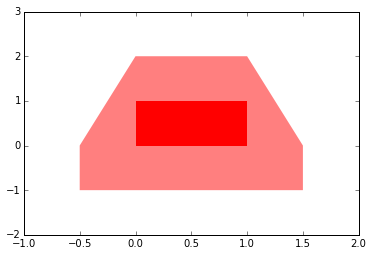

In [39]:
p = np.array([
        [0.0, 0.0],
        [1.0, 0.0],
        [1.0, 1.0],
        [0.0, 1.0],
    ])
q = np.array([
        [-0.5, -1.0],
        [ 0.5, -1.0],
        [ 0.0, 1.0],
    ])

out = minkowski_sum(p, q)
out = np.vstack([out, out[0, :]])

plt.gca().add_patch( matplotlib.patches.Polygon(out, facecolor = (1,0,0,0.5), edgecolor='none'))
plt.gca().add_patch( matplotlib.patches.Polygon(p, facecolor=(1,0,0,1), edgecolor='none'))
plt.gca().set_xlim(-1, 2)
plt.gca().set_ylim(-2, 3);